This notebook has been used to produce plots for my article on the relaxing of linear regression assumptions under the Roll model [(find it here)](https://medium.com/@lu.battistoni/relaxing-linear-regression-assumptions-a-roll-model-application-59e310dde6ce)

*I sadly forgot to set a seed when generating the plots for the article, so my plots here are slightly different*

In [73]:
# imports
import pandas as pd
import numpy as np

import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

In [74]:
def generate_correlated_normals(mean1, std1, mean2, std2, correlation, size=1):
    """
    Generate correlated normal random variables.

    Parameters:
    - mean1 (float): Mean of the first normal distribution.
    - std1 (float): Standard deviation of the first normal distribution.
    - mean2 (float): Mean of the second normal distribution.
    - std2 (float): Standard deviation of the second normal distribution.
    - correlation (float): Correlation coefficient between the two normal distributions.
    - size (int, optional): Number of samples to generate. Default is 1.

    Returns:
    - tuple: A tuple containing two arrays of correlated normal random variables.
    """
    # Calculate the covariance matrix
    cov_matrix = np.array([[std1**2, correlation * std1 * std2],
                           [correlation * std1 * std2, std2**2]])
    # Set the means
    mean = [mean1, mean2]
    # Generate correlated normal random variables
    correlated_normals = np.random.multivariate_normal(mean, cov_matrix, size=size).T
    # Return the arrays of correlated normal random variables
    return correlated_normals[0], correlated_normals[1]


def AR1_process_roll_model(phi, sigma_v, T):
    """
    Generate a path of an autoregressive process of order 1 (AR(1)).
    This is under the Roll Model assumptions, so the values of the
    process can either be -1 or 1.
    
    Parameters:
    - phi (float): The autoregressive parameter.
    - sigma_v (float): The standard deviation of the white noise.
    - T (int): The number of time steps.
    
    Returns:
    - numpy.ndarray: An array containing the generated path.
    """
    # Initialize an array to store the path
    path = np.zeros(T)

    # Generate the first value of the path
    path[0] = np.sign(np.random.uniform(-1, 1))
    
    # Generate the remaining values of the path
    for t in range(1, T):
        # Generate the white noise term
        v_t = np.random.normal(loc=0, scale=sigma_v)
        
        # Calculate the value of the AR(1) process
        value = phi * path[t-1] + v_t
        
        # Take the sign of the value to get +1 or -1
        path[t] = np.sign(value)

    return path


def generate_binary_correlated_variables(corr, size, err):
    """
    Generate binary correlated variables with a specified correlation coefficient.

    Parameters:
    - corr (float): Desired correlation coefficient between the two variables.
    - size (int): Number of samples to generate.
    - err (float): Maximum allowable error in correlation coefficient.

    Returns:
    - tuple: A tuple containing two arrays of binary correlated variables.
    """
    # Generate the first binary variable
    x = np.sign(np.random.normal(0, 1, size=size))
    
    # Introduce a shift in x to create correlation with y
    x_shifted = np.roll(x, 1)
    x_shifted[0] = 1
    
    # Adjust the variables until the desired correlation is achieved within the specified error
    # This code is not particularly efficient, but this is out of our notebook scope
    while abs(np.corrcoef(x, x_shifted)[0, 1] - corr) > err:
        # Generate a new set of random variables
        x = np.sign(np.random.normal(0, 1, size=size))
        x_shifted = np.roll(x, 1)
        x_shifted[0] = 1
    
    return x, x_shifted

In [75]:
# parameters
size = 2000 # number of datapoints
c = 0.8
sigma_v = 1.0
sigma_u = 1.0

OLS Regression Results of non correlated processes - Estimation of Roll model parameter

                            OLS Regression Results                            
Dep. Variable:              delta_p_t   R-squared:                       0.570
Model:                            OLS   Adj. R-squared:                  0.570
Method:                 Least Squares   F-statistic:                     2647.
Date:                Mon, 29 Apr 2024   Prob (F-statistic):               0.00
Time:                        22:46:52   Log-Likelihood:                -2842.0
No. Observations:                2000   AIC:                             5688.
Df Residuals:                    1998   BIC:                             5699.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0179      0.022      0.796      0.4

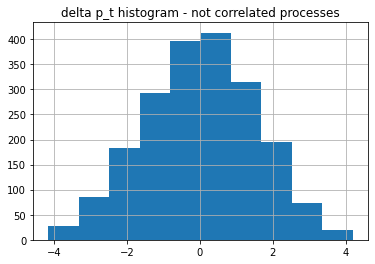

In [76]:
phi = 0  # AR(1) coefficient

# noise term
u_t = np.random.normal(loc=0, scale=sigma_u, size=size)

# AR(1) process for transactions direction
q_t = AR1_process_roll_model(phi, sigma_v, size)

# write everything in a dataframe for better readability
df = pd.DataFrame({'q_t': q_t, 'u_t': u_t})
df['q_t-1'] = df['q_t'].shift()

# let's assume that the first transaction is a buy
df = df.fillna(1)

# difference in subsequent transactions directions
df['delta_q_t'] = df['q_t'] - df['q_t-1']

# difference in subsequent transaction prices
df['delta_p_t'] = c * df['delta_q_t'] + df['u_t']

# plot
fig = plt.figure()
df['delta_p_t'].hist()
plt.title('delta p_t histogram - not correlated processes')

x = sm.add_constant(df['delta_q_t'])

# Fit OLS model
model = sm.OLS(df['delta_p_t'], x).fit()

# Print model summary
print(model.summary())

In [77]:
print(f"Simulated estimate for c = {round(model.params['delta_q_t'], 4)}")
print(f"Theoretical estimate for c = {c}")

Simulated estimate for c = 0.8156
Theoretical estimate for c = 0.8


In [78]:
print(f"The variance of the simulated process is {round(df['delta_p_t'].var(), 4)}")
print(f"The theoretical variance is {round(1 + 2*(c**2), 4)}")

The variance of the simulated process is 2.3358
The theoretical variance is 2.28


Violation of no autocorrelation assumption

Empirical correlation between q_t and q_t-1: 0.04995344771893839
                            OLS Regression Results                            
Dep. Variable:              delta_p_t   R-squared:                       0.535
Model:                            OLS   Adj. R-squared:                  0.535
Method:                 Least Squares   F-statistic:                     2301.
Date:                Mon, 29 Apr 2024   Prob (F-statistic):               0.00
Time:                        22:46:53   Log-Likelihood:                -2840.5
No. Observations:                2000   AIC:                             5685.
Df Residuals:                    1998   BIC:                             5696.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------

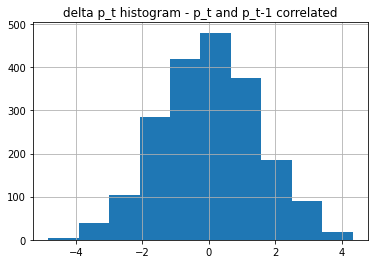

In [79]:
# Wanted correlation
phi = 0.05
err = 0.0001 # earling stopping condition

# Generate autocorrelated variables with correlation phi
q_t, q_t_1 = generate_binary_correlated_variables(phi, size, err)

# Empirical correlation
empirical_corr = np.corrcoef(q_t, q_t_1)[0, 1]
print("Empirical correlation between q_t and q_t-1:", empirical_corr)

# simulate the process
u_t = np.random.normal(loc=0, scale=sigma_u, size=size)
df = pd.DataFrame({'q_t': q_t, 'q_t-1': q_t_1, 'u_t': u_t})
df['delta_q_t'] = df['q_t'] - df['q_t-1']
df['delta_p_t'] = c * df['delta_q_t'] + df['u_t']

# plot
fig = plt.figure()
df['delta_p_t'].hist()
plt.title('delta p_t histogram - p_t and p_t-1 correlated')

x = sm.add_constant(df['delta_q_t'])

# Fit OLS model
model = sm.OLS(df['delta_p_t'], x).fit()

# Print model summary
print(model.summary())

In [80]:
print(f"Simulated estimate for c hat = {round(model.params['delta_q_t'], 4)}")
print(f"Theoretical estimate for c hat = {round(c * np.sqrt(1 - 2*phi), 4)}")

Simulated estimate for c hat = 0.7795
Theoretical estimate for c hat = 0.7589


In [81]:
print(f"The variance of the simulated process is {round(df['delta_p_t'].var(), 4)}")
print(f"The theoretical variance is {round(1 + 2*c*c*(1-phi), 4)}")

The variance of the simulated process is 2.1583
The theoretical variance is 2.216


In [82]:
print(f"The Durbin Watson statistics is {round(sm.stats.stattools.durbin_watson(q_t), 4)}")

The Durbin Watson statistics is 1.898


Violation of error and independent variable independency

                            OLS Regression Results                            
Dep. Variable:              delta_p_t   R-squared:                       0.774
Model:                            OLS   Adj. R-squared:                  0.774
Method:                 Least Squares   F-statistic:                     6834.
Date:                Mon, 29 Apr 2024   Prob (F-statistic):               0.00
Time:                        22:46:54   Log-Likelihood:                -2661.5
No. Observations:                2000   AIC:                             5327.
Df Residuals:                    1998   BIC:                             5338.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0042      0.020     -0.203      0.8

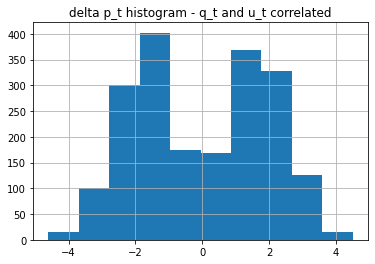

In [83]:
# Parameters of two normals
mean1 = 0
std1 = 1
mean2 = 0
std2 = 1
correlation = 0.5 # given correlation between distributions

path = np.zeros(size)

# Generate two correlated normals
q_t, u_t = generate_correlated_normals(mean1, std1, mean2, std2, correlation, size)

# generate process paths with correlated normal random variables
# this is as before, but with the difference that we generated correlated random variables
path[0] = np.sign(np.random.uniform(-1,1))
for t in range(1, size):
    value = q_t[t] - path[t-1] + u_t[t]
    path[t] = np.sign(value)
    
df = pd.DataFrame({'q_t': path, 'u_t': u_t})
df['q_t-1'] = df['q_t'].shift()
df = df.fillna(1)
df['delta_q_t'] = df['q_t'] - df['q_t-1']
df['delta_p_t'] = c * df['delta_q_t'] + df['u_t']

# plot
fig = plt.figure()
df['delta_p_t'].hist()
plt.title('delta p_t histogram - q_t and u_t correlated')

x = sm.add_constant(df['delta_q_t'])

# Fit OLS model
model = sm.OLS(df['delta_p_t'], x).fit()

# Print model summary
print(model.summary())

In [84]:
print(f"Simulated estimate for c hat = {round(model.params['delta_q_t'], 4)}")
print(f"Theoretical estimate for c hat = {round(np.sqrt(c * (correlation + c)), 4)}")

Simulated estimate for c hat = 0.9947
Theoretical estimate for c hat = 1.0198


In [85]:
print(f"The variance of the simulated process is {round(df['delta_p_t'].var(), 4)}")
print(f"The theoretical variance is {round(2*c*c + 1 + 2*c*correlation*1, 4)}")

The variance of the simulated process is 3.7076
The theoretical variance is 3.08


In [86]:
corr, p_value = pearsonr(df['q_t'], df['u_t'])
print(f"Correlation between independent variable and residuals: {round(corr, 4)}")
print(f"Correlation test p-value: {round(p_value, 4)}")

Correlation between independent variable and residuals: 0.5827
Correlation test p-value: 0.0
